**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, pairwise

from scipy.spatial import distance
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.sparse import issparse

MAX_FEATURES = None

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self._tree = None
        self.metric = metric
    
    def fit(self, X, y):
        def metric_euclidean(vec):
            if issparse(vec):
                return pairwise.pairwise_distances(vec, self._data, metric=self.metric)
            elif isinstance(vec, np.ndarray):
                return np.linalg.norm(self._data - vec, axis=1)
            else:
                raise NotImplementedError()
        def metric_cosine(vec):
            if issparse(vec):
                return pairwise.pairwise_distances(vec, self._data, metric=self.metric)
            elif isinstance(vec, np.ndarray):
                return np.array([distance.cosine(vec, dvec) for dvec in self._data])
            else:
                raise NotImplementedError()

        self._data = X
        self._target = y
        if self.algorithm == 'kd_tree':
            self._tree = KDTree(X)
        if self.metric == 'euclidean':
            self._metric = metric_euclidean
        elif self.metric == 'cosine':
            self._metric = metric_cosine
        return self
    
    def predict(self, X):
        if self.algorithm == 'brute':
            result = np.zeros(X.shape[0], dtype=int)
            if type(X) is np.ndarray:
                for i in range(X.shape[0]):
                    indexes = np.argpartition(self._metric(X[i]), self.n_neighbors)[:self.n_neighbors]
                    result[i] = np.argmax(np.bincount(self._target[indexes]))
                    # для менее удачного датасета пришлось бы использовать np.unique
            elif issparse(X):
                # sparse matrix way
                metrics_arr = self._metric(X)
                for i in range(X.shape[0]):
                    indexes = np.argpartition(metrics_arr[i], self.n_neighbors)[:self.n_neighbors]
                    result[i] = np.argmax(np.bincount(self._target[indexes]))
            return result
        if self.algorithm == 'kd_tree':
            result = np.zeros(X.shape[0], dtype=int)
            dist, indexes = self._tree.query(X, k=2)
            for i in range(X.shape[0]):
                result[i] = np.argmax(np.bincount(self._target[indexes[i]]))
            return result

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 563 µs, sys: 119 µs, total: 682 µs
Wall time: 571 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 15.7 µs


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [10]:
%time clf.predict(X_test)

CPU times: user 2.72 ms, sys: 1.21 ms, total: 3.93 ms
Wall time: 2.89 ms


array([1, 0, 1, 2, 2, 1, 0, 1, 0, 2, 2, 0, 0, 1, 1])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 2 ms, sys: 1.56 ms, total: 3.56 ms
Wall time: 2.13 ms


array([1, 0, 1, 2, 2, 1, 0, 1, 0, 2, 2, 0, 0, 1, 1])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 2.29 ms, sys: 2.84 ms, total: 5.13 ms
Wall time: 41.5 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 207 µs, sys: 35 µs, total: 242 µs
Wall time: 239 µs


MyKNeighborsClassifier(algorithm='kd_tree', metric='euclidean', n_neighbors=2)

In [16]:
%time clf.predict(X_test)

CPU times: user 3.25 ms, sys: 1.84 ms, total: 5.09 ms
Wall time: 11 ms


array([0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 0, 1])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 485 µs, sys: 163 µs, total: 648 µs
Wall time: 505 µs


array([0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 0, 1])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer(max_features=MAX_FEATURES, stop_words=ENGLISH_STOP_WORDS)
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
score = cross_val_score(MyKNeighborsClassifier(n_neighbors=5), X, target, cv=3)
score

array([0.22560976, 0.19915142, 0.22381331])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
MAX_NEIGHBORS = 10
x_axis = np.arange(1, MAX_NEIGHBORS +1)
def get_top_score(X, classifier, metric='euclidean', max_neighbors=MAX_NEIGHBORS, return_scores=True):
    scores = np.zeros(max_neighbors + 1)
    for i in range(1, max_neighbors + 1):
        scores[i] = np.mean(cross_val_score(classifier(n_neighbors=i, metric=metric), X, target, cv=3))
    top = scores[2:].argmax() + 2, scores[2:].max()
    if return_scores:
        return (top, scores[1:])
    return top

scores = get_top_score(X, MyKNeighborsClassifier, return_scores=True)

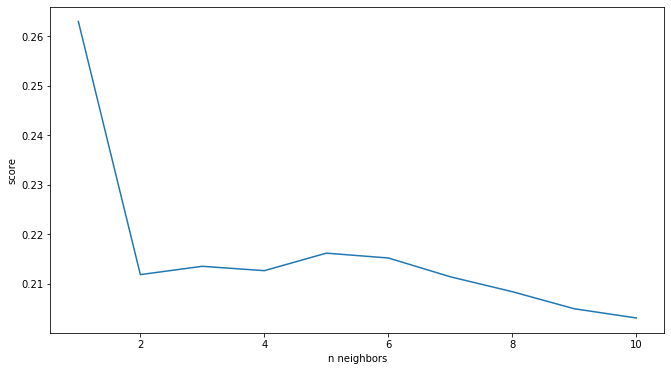

(5, 0.2161914956460623)

In [24]:
plt.rcParams['figure.figsize'] = [11, 6]
plt.rcParams['figure.facecolor'] = 'xkcd:white'
plt.plot(x_axis, scores[1])
plt.xlabel('n neighbors')
plt.ylabel('score')
plt.show()
scores[0]

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [25]:
scores_cos = get_top_score(X, MyKNeighborsClassifier, metric='cosine')
scores_cos[0]

(10, 0.5627535406999464)

In [26]:
X_tfidf = TfidfVectorizer(max_features=MAX_FEATURES, stop_words=ENGLISH_STOP_WORDS).fit_transform(data)
scores_tfidf = get_top_score(X_tfidf, MyKNeighborsClassifier)
scores_tfidf[0]

(3, 0.09925721485778378)

In [27]:
scores_tfidf_cos = get_top_score(X_tfidf, MyKNeighborsClassifier, metric='cosine')
scores_tfidf_cos[0]

(10, 0.6681106365212592)

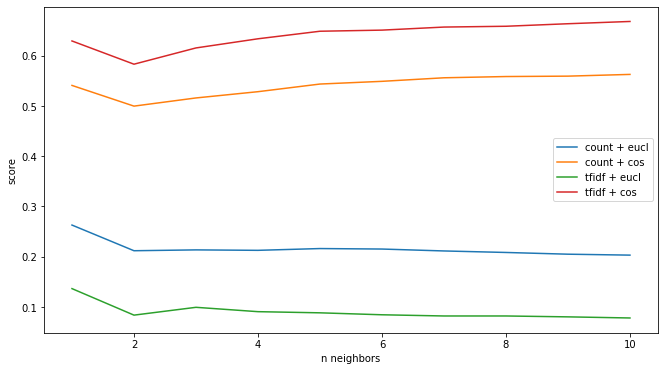

In [28]:
plt.rcParams['figure.figsize'] = [11, 6]
plt.rcParams['figure.facecolor'] = 'xkcd:white'
plt.plot(x_axis, scores[1], label='count + eucl')
plt.plot(x_axis, scores_cos[1], label='count + cos')
plt.plot(x_axis, scores_tfidf[1], label='tfidf + eucl')
plt.plot(x_axis, scores_tfidf_cos[1], label='tfidf + cos')
plt.legend()
plt.xlabel('n neighbors')
plt.ylabel('score')
plt.show()
cmp = np.array([scores, scores_cos, scores_tfidf, scores_tfidf_cos])

Косинусная метрика улучшает качество модели для каждого из векторизаторов. Лучше всего работает модель TfIdf с косинусной метрикой, при этом TfIdf с евклидовой метрикой показывает худшие результаты. Можно сказать, что TfIdf более чувствителен к правильному выбору метрики.

В итоге побеждает TfIdf + cos

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [29]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [30]:
vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words=ENGLISH_STOP_WORDS)
X = vectorizer.fit_transform(newsgroups['data'])
vectorizer_test = TfidfVectorizer(max_features=MAX_FEATURES, stop_words=ENGLISH_STOP_WORDS,
                                 vocabulary=vectorizer.get_feature_names())
X_test = vectorizer_test.fit_transform(newsgroups_test['data'])
clf = MyKNeighborsClassifier(n_neighbors=10, metric='cosine').fit(X, newsgroups['target'])
accuracy_score(newsgroups_test['target'], clf.predict(X_test))

0.5994423791821561

Точность модели на тестовой выборке несколько ниже, чем на кросс-валидации. Небольшие различия говорят о хорошем разбиении выборки на train и test и о том, что модель неплохо предсказывает. В целом, оценка кросс-валидации позволяет только настраивать неструктурные параметры. В данном случае это метрика и векторизатор.

In [31]:
vectorizer = CountVectorizer(max_features=MAX_FEATURES, stop_words=ENGLISH_STOP_WORDS)
X = vectorizer.fit_transform(newsgroups['data'])
vectorizer_test = CountVectorizer(max_features=MAX_FEATURES, stop_words=ENGLISH_STOP_WORDS,
                                 vocabulary=vectorizer.get_feature_names())
X_test = vectorizer_test.fit_transform(newsgroups_test['data'])
clf = MyKNeighborsClassifier(n_neighbors=10, metric='cosine').fit(X, newsgroups['target'])
accuracy_score(newsgroups_test['target'], clf.predict(X_test))

0.5010621348911312

CountVectorizer с косинусной метрикой дает схожие результаты, но точность несколько хуже, чем у TfIdf.